In [1]:
def run_esn_quantization(N, bit_width):
    from reservoirpy.datasets import mackey_glass
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    from brevitas.nn import QuantIdentity
    import numpy as np
    import torch
    from reservoirpy import Node

    # Prepare Lorenz dataset
    X = mackey_glass(10000)
    X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

    train_len = 5000
    threshold_scale = 1.0 / (2 ** bit_width) 

    # Initialize and train ESN (FP32)
    reservoir = Reservoir(N, lr=1, sr=0.9, input_connectivity=0.4, rc_connectivity=0.1, input_scaling=1)
    readout = Ridge(ridge=1e-5)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(X[:train_len], X[1:train_len + 1], warmup=1000)

    # Quantization helper
    def extract_Qinput(input_array, num_bits):
        quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
        float_input = torch.tensor(input_array, dtype=torch.float64)
        quant_input = quant_identity(float_input)
        return (
            quant_input.int().detach().numpy(),
            quant_input.scale.detach().numpy(),
            quant_input.zero_point.detach().numpy()
        )

    # Extract quantized versions
    int_x, x_scale, _ = extract_Qinput(X, num_bits=bit_width)
    int_Win, scale_Win, _ = extract_Qinput(esn_model.nodes[0].Win.todense(), num_bits=bit_width)
    int_Wr, scale_Wr, _ = extract_Qinput(esn_model.nodes[0].W.todense(), num_bits=bit_width)
    int_bias, _, _ = extract_Qinput(esn_model.nodes[0].bias.todense(), num_bits=bit_width)

    input_scale = (scale_Win * x_scale)
    reservoir_scale = (scale_Wr * threshold_scale)

    def compute_integer_thresholds(scale):
        return np.int32(-1 / scale), np.int64(1 / scale)

    a_scaled, b_scaled = compute_integer_thresholds(input_scale)
    c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

    def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, div_scale):
        x = np.clip(x, a_scaled, b_scaled)
        x = x + b_scaled
        return (x / div_scale).astype(np.int64)

    div_scale = 2 ** bit_width

    def forward2(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int64).reshape(1, N)
        r = state @ node.Wr.astype(np.int64)
        s = x @ node.Win.astype(np.int64).T
        s = s.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, div_scale)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, div_scale)
        return out_r + out_s + node.Bias.reshape(1, N)

    def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
        if x is not None:
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Wr", int_Wr)
            node.set_param("Win", int_Win)
            node.set_param("Bias", int_bias)

    class CustomNode(Node):
        def __init__(self, name=None):
            super().__init__(
                forward=forward2,
                initializer=initialize,
                params={"Wr": None, "Win": None, "Bias": None},
                hypers={},
                name=name
            )

    node = CustomNode(name=f"quant_reservoir_N{N}_b{bit_width}")
    esn_model_PTQ = node >> readout

    Quantized_States = node.run(int_x[:train_len].astype(np.float64)) * threshold_scale
    readout.fit(Quantized_States, X[1:train_len + 1], warmup=1000)

    Quantized_States_test = node.run(int_x[train_len+1:-1].astype(np.float64)) * threshold_scale
    Y_pred_PTQ = readout.run(Quantized_States_test)

    # Evaluation
    a="R\u00B2"

    Y_true = X[train_len + 2:]
    return {
        "N": N,
        "bits": bit_width,
        "RMSE": rmse(Y_true, Y_pred_PTQ),
        "NRMSE": nrmse(Y_true, Y_pred_PTQ),
        "R\u00B2": rsquare(Y_true, Y_pred_PTQ)
    }


In [2]:
def run_esn_float(N):
    from reservoirpy.datasets import lorenz
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    import numpy as np

    # Prepare Lorenz dataset
    X = lorenz(10000)
    X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

    train_len = 5000

    reservoir = Reservoir(N, lr=1, sr=0.9, input_connectivity=0.4, rc_connectivity=0.1, input_scaling=1)
    readout = Ridge(ridge=1e-5)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(X[:train_len], X[1:train_len + 1], warmup=400)

    Y_pred = esn_model.run(X[train_len+1:-1])
    Y_true = X[train_len + 2:]

    return {
        "N": N,
        "bits": "FP",
        "RMSE": rmse(Y_true, Y_pred),
        "NRMSE": nrmse(Y_true, Y_pred),
        "R\u00B2": rsquare(Y_true, Y_pred)
    }


In [3]:
# Define parameter sets
N_list = [50,100, 150, 200, 250, 300, 350, 400, 450, 500]
bit_width_list = [4, 6, 8,16]

results = []

# Step 1: Run float (baseline) for each N
for N in N_list:
    print(f"Running float (FP32) evaluation for N={N}...")
    float_result = run_esn_float(N)
    results.append(float_result)

# Step 2: Run quantized evaluations
for N in N_list:
    for bits in bit_width_list:
        print(f"Running quantized evaluation for N={N}, bit_width={bits}...")
        quant_result = run_esn_quantization(N, bits)
        results.append(quant_result)

# Step 3: Create DataFrame and save
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)

# Optional: Save to CSV
df_results.to_csv("quantized_and_float_esn_results.csv", index=False)


Running float (FP32) evaluation for N=50...


Running Model-0: 5000it [00:00, 18645.43it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Fitting node Ridge-0...


Running Model-0: 4998it [00:00, 20104.10it/s]         


Running float (FP32) evaluation for N=100...


Running Model-1: 5000it [00:00, 18299.29it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-1...


Running Model-1: 4998it [00:00, 18337.88it/s]         


Running float (FP32) evaluation for N=150...


Running Model-2: 5000it [00:00, 17579.75it/s]?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-2...


Running Model-2: 4998it [00:00, 17659.62it/s]         


Running float (FP32) evaluation for N=200...


Running Model-3: 5000it [00:00, 17546.95it/s]?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-3...


Running Model-3: 4998it [00:00, 17537.54it/s]         


Running float (FP32) evaluation for N=250...


Running Model-4: 5000it [00:00, 16611.33it/s]?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-4...


Running Model-4: 4998it [00:00, 17021.50it/s]         


Running float (FP32) evaluation for N=300...


Running Model-5: 5000it [00:00, 16387.24it/s]?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-5...


Running Model-5: 4998it [00:00, 16678.02it/s]         


Running float (FP32) evaluation for N=350...


Running Model-6: 5000it [00:00, 15961.60it/s]?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-6...


Running Model-6: 4998it [00:00, 14934.74it/s]         


Running float (FP32) evaluation for N=400...


Running Model-7: 5000it [00:00, 15418.94it/s]?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-7...


Running Model-7: 4998it [00:00, 15910.33it/s]         


Running float (FP32) evaluation for N=450...


Running Model-8: 5000it [00:00, 15210.74it/s]?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-8...


Running Model-8: 4998it [00:00, 14568.23it/s]         


Running float (FP32) evaluation for N=500...


Running Model-9: 5000it [00:00, 14561.30it/s]?, ?it/s]
Running Model-9: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-9...


Running Model-9: 4998it [00:00, 14162.91it/s]         


Running quantized evaluation for N=50, bit_width=4...


Running Model-10: 5000it [00:00, 17661.94it/s]?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
/home/atousa/.local/lib/python3.10/site-packages/torch/_tensor.py:1644: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1935.)
  return super().rename(names)


Fitting node Ridge-10...


Running Ridge-10: 100%|██████████| 4998/4998 [00:00<00:00, 118460.53it/s]


Running quantized evaluation for N=50, bit_width=6...


Running Model-12: 5000it [00:00, 18394.63it/s]?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-11...


Running Ridge-11: 100%|██████████| 4998/4998 [00:00<00:00, 144305.61it/s]


Running quantized evaluation for N=50, bit_width=8...


Running Model-14: 5000it [00:00, 18268.08it/s]?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-12...


Running Ridge-12: 100%|██████████| 4998/4998 [00:00<00:00, 139950.14it/s]


Running quantized evaluation for N=50, bit_width=16...


Running Model-16: 5000it [00:00, 17344.05it/s]?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-13...


Running Ridge-13: 100%|██████████| 4998/4998 [00:00<00:00, 140528.05it/s]


Running quantized evaluation for N=100, bit_width=4...


Running Model-18: 5000it [00:00, 18782.63it/s]?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Fitting node Ridge-14...


Running Ridge-14: 100%|██████████| 4998/4998 [00:00<00:00, 128930.10it/s]


Running quantized evaluation for N=100, bit_width=6...


Running Model-20: 5000it [00:00, 18642.61it/s]?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Fitting node Ridge-15...


Running Ridge-15: 100%|██████████| 4998/4998 [00:00<00:00, 139246.42it/s]


Running quantized evaluation for N=100, bit_width=8...


Running Model-22: 5000it [00:00, 18122.33it/s]?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-16...


Running Ridge-16: 100%|██████████| 4998/4998 [00:00<00:00, 142596.64it/s]


Running quantized evaluation for N=100, bit_width=16...


Running Model-24: 5000it [00:00, 18854.86it/s]?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
/tmp/ipykernel_2505807/951905858.py:44: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int64(1 / scale)


Fitting node Ridge-17...


Running Ridge-17: 100%|██████████| 4998/4998 [00:00<00:00, 144740.02it/s]


Running quantized evaluation for N=150, bit_width=4...


Running Model-26: 5000it [00:00, 17981.84it/s]?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-18...


Running Ridge-18: 100%|██████████| 4998/4998 [00:00<00:00, 144674.09it/s]


Running quantized evaluation for N=150, bit_width=6...


Running Model-28: 5000it [00:00, 18207.23it/s]?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-19...


Running Ridge-19: 100%|██████████| 4998/4998 [00:00<00:00, 126983.10it/s]


Running quantized evaluation for N=150, bit_width=8...


Running Model-30: 5000it [00:00, 18142.18it/s]?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-20...


Running Ridge-20: 100%|██████████| 4998/4998 [00:00<00:00, 142781.17it/s]


Running quantized evaluation for N=150, bit_width=16...


Running Model-32: 5000it [00:00, 18139.23it/s]?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Fitting node Ridge-21...


Running Ridge-21: 100%|██████████| 4998/4998 [00:00<00:00, 143077.42it/s]


Running quantized evaluation for N=200, bit_width=4...


Running Model-34: 5000it [00:00, 17728.66it/s]?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Fitting node Ridge-22...


Running Ridge-22: 100%|██████████| 4998/4998 [00:00<00:00, 127344.88it/s]


Running quantized evaluation for N=200, bit_width=6...


Running Model-36: 5000it [00:00, 17907.98it/s]?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-23...


Running Ridge-23: 100%|██████████| 4998/4998 [00:00<00:00, 139854.90it/s]


Running quantized evaluation for N=200, bit_width=8...


Running Model-38: 5000it [00:00, 17006.74it/s]?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-24...


Running Ridge-24: 100%|██████████| 4998/4998 [00:00<00:00, 142626.71it/s]


Running quantized evaluation for N=200, bit_width=16...


Running Model-40: 5000it [00:00, 17620.11it/s]?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-25...


Running Ridge-25: 100%|██████████| 4998/4998 [00:00<00:00, 140381.25it/s]


Running quantized evaluation for N=250, bit_width=4...


Running Model-42: 5000it [00:00, 17430.18it/s]?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-26...


Running Ridge-26: 100%|██████████| 4998/4998 [00:00<00:00, 141634.17it/s]


Running quantized evaluation for N=250, bit_width=6...


Running Model-44: 5000it [00:00, 17434.35it/s]?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-27...


Running Ridge-27: 100%|██████████| 4998/4998 [00:00<00:00, 141349.57it/s]


Running quantized evaluation for N=250, bit_width=8...


Running Model-46: 5000it [00:00, 17413.42it/s]?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-28...


Running Ridge-28: 100%|██████████| 4998/4998 [00:00<00:00, 140979.79it/s]


Running quantized evaluation for N=250, bit_width=16...


Running Model-48: 5000it [00:00, 17393.70it/s]?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-29...


Running Ridge-29: 100%|██████████| 4998/4998 [00:00<00:00, 142416.45it/s]


Running quantized evaluation for N=300, bit_width=4...


Running Model-50: 5000it [00:00, 16733.74it/s]?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-30...


Running Ridge-30: 100%|██████████| 4998/4998 [00:00<00:00, 121730.05it/s]


Running quantized evaluation for N=300, bit_width=6...


Running Model-52: 5000it [00:00, 16985.60it/s]?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-31...


Running Ridge-31: 100%|██████████| 4998/4998 [00:00<00:00, 140737.50it/s]


Running quantized evaluation for N=300, bit_width=8...


Running Model-54: 5000it [00:00, 16806.38it/s]?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-32...


Running Ridge-32: 100%|██████████| 4998/4998 [00:00<00:00, 140353.99it/s]


Running quantized evaluation for N=300, bit_width=16...


Running Model-56: 5000it [00:00, 16994.60it/s]?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-33...


Running Ridge-33: 100%|██████████| 4998/4998 [00:00<00:00, 131470.68it/s]


Running quantized evaluation for N=350, bit_width=4...


Running Model-58: 5000it [00:00, 16481.65it/s]?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-34...


Running Ridge-34: 100%|██████████| 4998/4998 [00:00<00:00, 139659.24it/s]


Running quantized evaluation for N=350, bit_width=6...


Running Model-60: 5000it [00:00, 16333.58it/s]?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-35...


Running Ridge-35: 100%|██████████| 4998/4998 [00:00<00:00, 135780.37it/s]


Running quantized evaluation for N=350, bit_width=8...


Running Model-62: 5000it [00:00, 16241.68it/s]?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-36...


Running Ridge-36: 100%|██████████| 4998/4998 [00:00<00:00, 142352.62it/s]


Running quantized evaluation for N=350, bit_width=16...


Running Model-64: 5000it [00:00, 16471.32it/s]?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-37...


Running Ridge-37: 100%|██████████| 4998/4998 [00:00<00:00, 141329.56it/s]


Running quantized evaluation for N=400, bit_width=4...


Running Model-66: 5000it [00:00, 16148.94it/s]?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-38...


Running Ridge-38: 100%|██████████| 4998/4998 [00:00<00:00, 141025.32it/s]


Running quantized evaluation for N=400, bit_width=6...


Running Model-68: 5000it [00:00, 15876.58it/s]?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-39...


Running Ridge-39: 100%|██████████| 4998/4998 [00:00<00:00, 140054.86it/s]


Running quantized evaluation for N=400, bit_width=8...


Running Model-70: 5000it [00:00, 15824.07it/s]?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-40...


Running Ridge-40: 100%|██████████| 4998/4998 [00:00<00:00, 140545.01it/s]


Running quantized evaluation for N=400, bit_width=16...


Running Model-72: 5000it [00:00, 16086.19it/s]?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-41...


Running Ridge-41: 100%|██████████| 4998/4998 [00:00<00:00, 141541.41it/s]


Running quantized evaluation for N=450, bit_width=4...


Running Model-74: 5000it [00:00, 15640.77it/s]?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-42...


Running Ridge-42: 100%|██████████| 4998/4998 [00:00<00:00, 141454.49it/s]


Running quantized evaluation for N=450, bit_width=6...


Running Model-76: 5000it [00:00, 15285.49it/s]?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-43...


Running Ridge-43: 100%|██████████| 4998/4998 [00:00<00:00, 116882.62it/s]


Running quantized evaluation for N=450, bit_width=8...


Running Model-78: 5000it [00:00, 15635.42it/s]?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-44...


Running Ridge-44: 100%|██████████| 4998/4998 [00:00<00:00, 141004.45it/s]


Running quantized evaluation for N=450, bit_width=16...


Running Model-80: 5000it [00:00, 15728.44it/s]?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-45...


Running Ridge-45: 100%|██████████| 4998/4998 [00:00<00:00, 140570.46it/s]


Running quantized evaluation for N=500, bit_width=4...


Running Model-82: 5000it [00:00, 15021.56it/s]?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Fitting node Ridge-46...


Running Ridge-46: 100%|██████████| 4998/4998 [00:00<00:00, 129728.77it/s]


Running quantized evaluation for N=500, bit_width=6...


Running Model-84: 5000it [00:00, 15038.90it/s]?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Fitting node Ridge-47...


Running Ridge-47: 100%|██████████| 4998/4998 [00:00<00:00, 138727.62it/s]


Running quantized evaluation for N=500, bit_width=8...


Running Model-86: 5000it [00:00, 14930.15it/s]?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-48...


Running Ridge-48: 100%|██████████| 4998/4998 [00:00<00:00, 140005.29it/s]


Running quantized evaluation for N=500, bit_width=16...


Running Model-88: 5000it [00:00, 15003.34it/s]?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-49...


Running Ridge-49: 100%|██████████| 4998/4998 [00:00<00:00, 135154.45it/s]


      N bits      RMSE     NRMSE        R²
0    50   FP  0.000450  0.000229  0.999999
1   100   FP  0.000343  0.000174  0.999999
2   150   FP  0.000406  0.000206  0.999999
3   200   FP  0.000395  0.000201  0.999999
4   250   FP  0.000396  0.000201  0.999999
5   300   FP  0.000357  0.000181  0.999999
6   350   FP  0.000353  0.000179  0.999999
7   400   FP  0.000354  0.000180  0.999999
8   450   FP  0.000421  0.000214  0.999999
9   500   FP  0.000294  0.000150  0.999999
10   50    4  0.078624  0.039346  0.974281
11   50    6  0.033925  0.016977  0.995212
12   50    8  0.014848  0.007431  0.999083
13   50   16  0.002964  0.001483  0.999963
14  100    4  0.075810  0.037938  0.976089
15  100    6  0.029282  0.014654  0.996433
16  100    8  0.012966  0.006489  0.999301
17  100   16  0.003077  0.001540  0.999961
18  150    4  0.071421  0.035741  0.978778
19  150    6  0.029443  0.014734  0.996393
20  150    8  0.012642  0.006326  0.999335
21  150   16  0.003113  0.001558  0.999960
22  200    

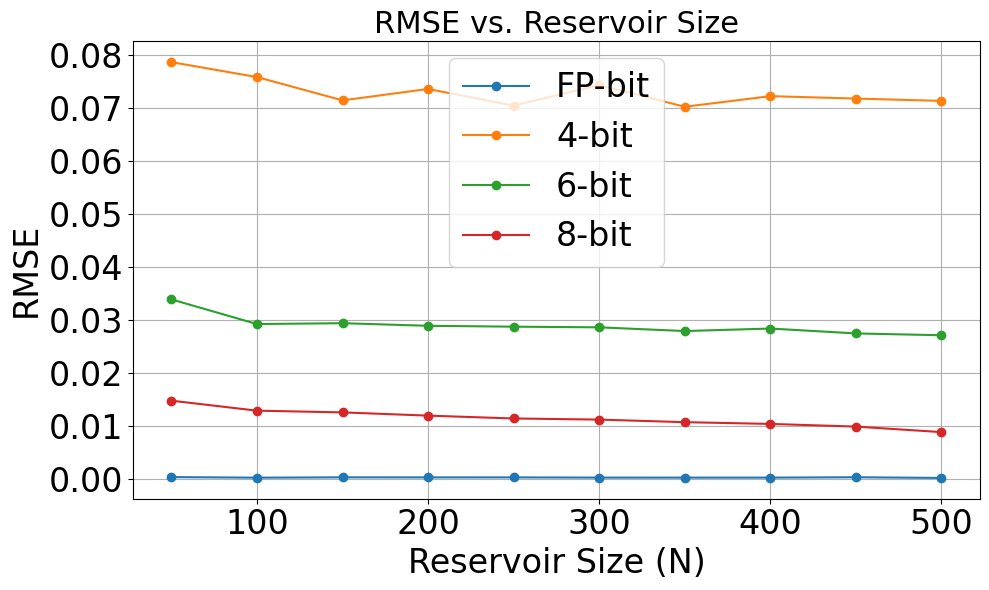

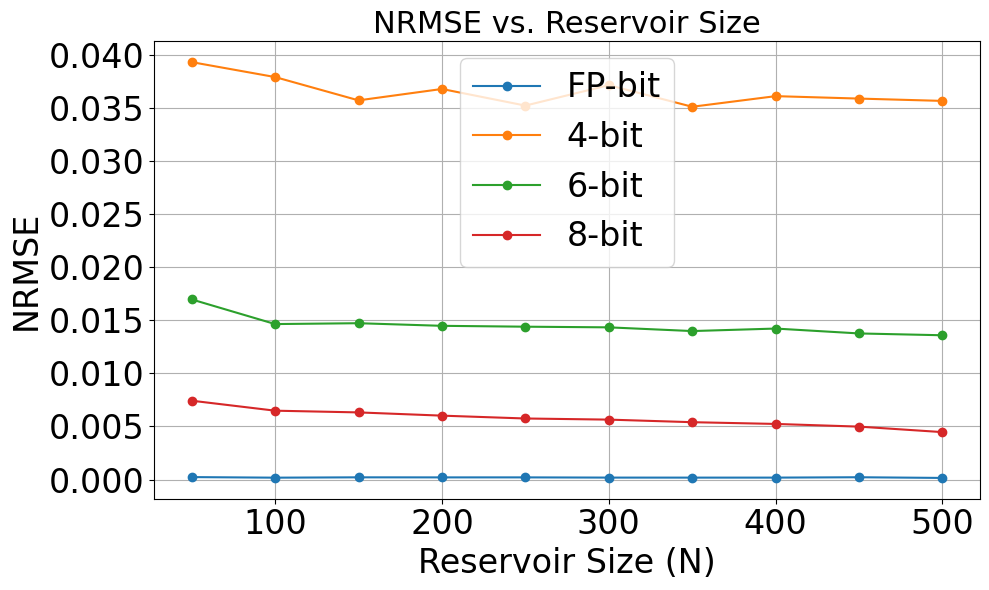

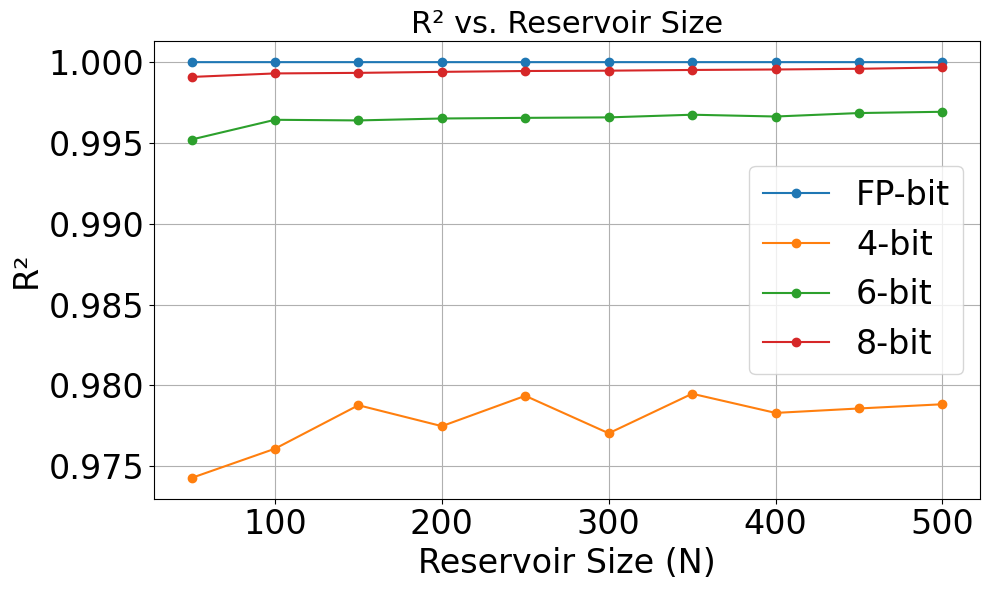

In [4]:
import matplotlib.pyplot as plt

for metric in ['RMSE', 'NRMSE', 'R\u00B2']:
    plt.figure(figsize=(10, 6))
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        plt.plot(subset['N'], subset[metric], marker='o', label=f"{bits}-bit")

    plt.title(f"{metric} vs. Reservoir Size", fontsize=22)
    plt.xlabel("Reservoir Size (N)", fontsize=24)
    plt.ylabel(metric, fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


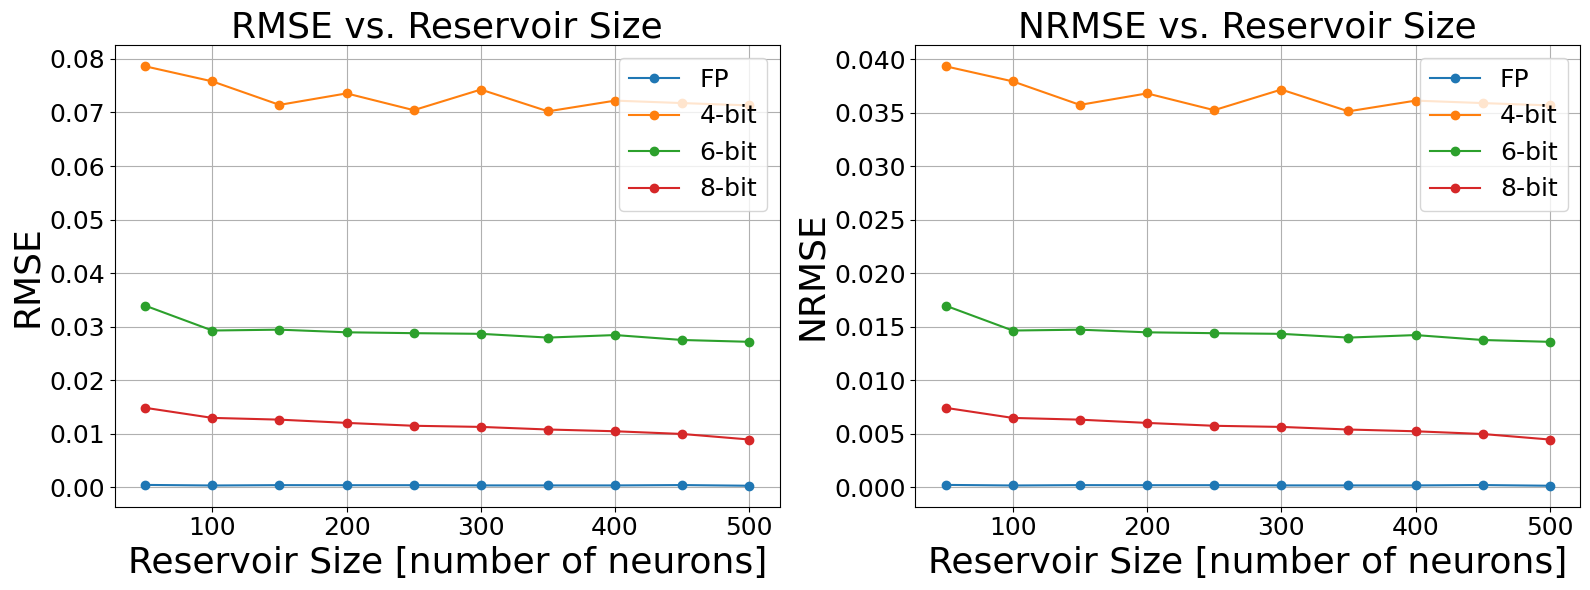

In [5]:
import matplotlib.pyplot as plt

metrics = ['RMSE', 'NRMSE']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        # only add "-bit" suffix for the numeric entries
        if bits == 'FP':
            label = 'FP'
        else:
            label = f"{bits}-bit"
        ax.plot(subset['N'], subset[metric], marker='o', label=label)

    ax.set_title(f"{metric} vs. Reservoir Size", fontsize=26)
    ax.set_xlabel("Reservoir Size [number of neurons]", fontsize=26)
    ax.set_ylabel(metric, fontsize=26)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig("macky.pdf", bbox_inches='tight')
plt.show()


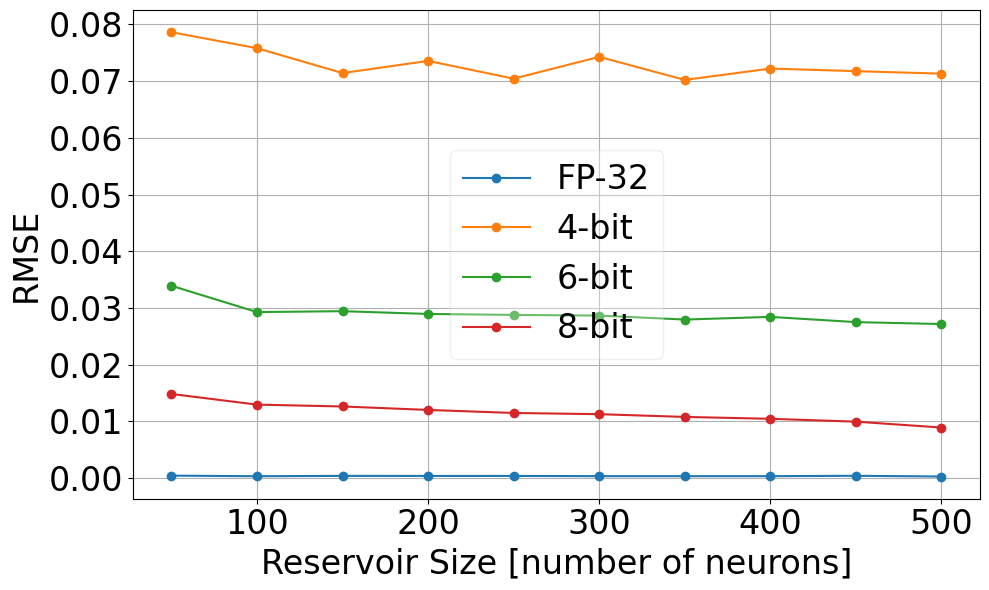

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for bits in ['FP', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"
    plt.plot(subset['N'], subset['RMSE'], marker='o', label=label)

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.tight_layout()

# Transparent legend and more space from top
plt.legend(fontsize=24, framealpha=0.3, loc='center')

plt.savefig("macky.pdf", bbox_inches='tight')
plt.show()

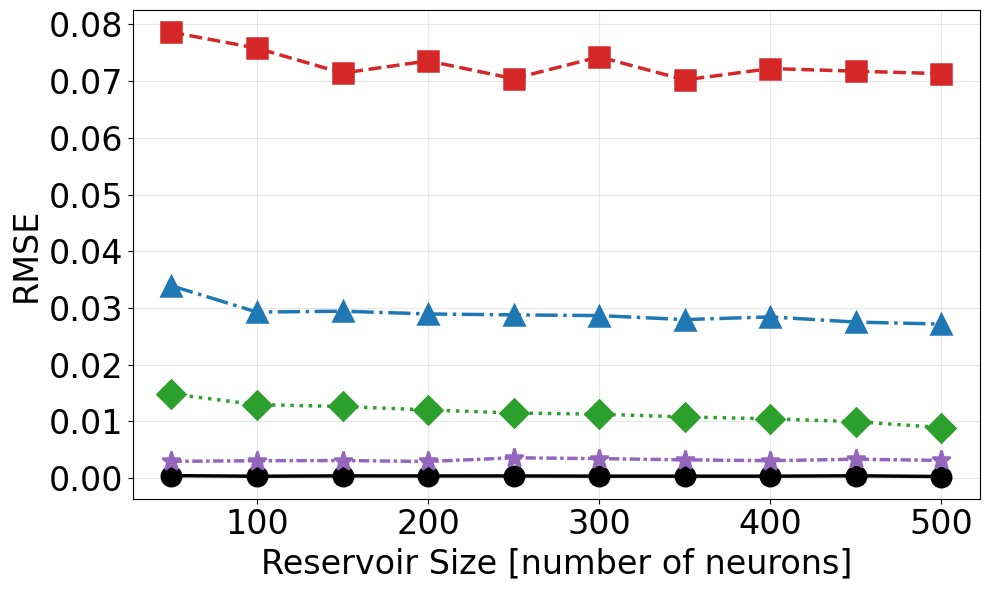

In [7]:
import matplotlib.pyplot as plt

# Define styles
styles = {
    'FP':  dict(color='black',      linestyle='-',  marker='o'),
    4:     dict(color='tab:red',    linestyle='--', marker='s'),
    6:     dict(color='tab:blue',   linestyle='-.', marker='^'),
    8:     dict(color='tab:green',  linestyle=':',  marker='D'),
    16:    dict(color='tab:purple', linestyle=(0, (3, 1, 1, 1)), marker='*')
}

plt.figure(figsize=(10, 6))

for bits in ['FP', 4, 6, 8, 16]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"

    plt.plot(
        subset['N'],
        subset['RMSE'],
        label=label,
        linewidth=2.5,
        markersize=14,          # bigger markers
        markeredgewidth=1.8,    # thicker marker border

        **styles[bits]
    )

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("macky_R.pdf", bbox_inches='tight')
plt.show()


In [8]:
print("R\u00B2")

R²
